# Job Queue Demo: Qubit Spectroscopy + Amplitude Rabi

This notebook demonstrates the job queue using **CharacterizationRunner**.

**Workflow:**
1. **Qubit Spectroscopy** - Find the qubit frequency
2. **Amplitude Rabi** - Calibrate pulse amplitude using the found frequency

The only difference from local execution is adding `job_client` and `user` to the runner.

## Prerequisites

Start the server and worker in separate terminals (only once for the fridge!):

```bash
# Terminal 1: Start the FastAPI server
cd D:\python\multimode_expts
pixi run python -u -m uvicorn job_server.server:app --host 0.0.0.0 --port 8000
# Note that if you are having problems here, it's possible that you accidentally started another server with a different host but some port. If so, double check this should only have 1 entry (in bash shell)
netstat -ano | grep :8000 | grep LISTENING

# Terminal 2: Start the worker (mock mode for testing)
# If you try to start a second worker and there is already one existing, an error will be thrown.
pixi run python -u -m job_server.worker [--mock]
```

## Setup

In [1]:
import sys
import os

# Add multimode_expts to path for imports
# Adjust this path if running from a different location
# sys.path.insert(0, "/Users/conniemiao/GDriveStanford/SchusterLab/local_multimode/multimode_expts")

from copy import deepcopy

import experiments as meas
from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner
from job_server import JobClient
from job_server.mock_hardware import MockStation

# Initialize station (mock for demo)
# station = MockStation(experiment_name="job_queue_demo")
station = MultimodeStation(experiment_name='job_queue_demo')

# Initialize job client
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']
Creating a copy of the dataset at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Data, plots, logs will be stored in: D:\experiments\job_queue_demo
Hardware configs will be read from D:\python\multimode_expts\configs\hardware_config_202505.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope m

## Qubit Spectroscopy

In [10]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
gespec_defaults = AttrDict(dict(    
    # start=center-span/2,  # [MHz]
    # step=span/expts,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=100,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=[0],
    qubits=[0],
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values


def gespec_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)

    span = kwargs.pop('span', 20)  # MHz
    center = kwargs.pop('center', station.config_thisrun.device.qubit.f_ge[0])
    expts = kwargs.pop('expts', default_expt_cfg.expts)

    expt_cfg.start = center - span / 2
    expt_cfg.step = span / expts
    
    expt_cfg.update(kwargs)
    return expt_cfg

def gespec_postproc(station, expt):
    old_freq = station.config_thisrun.device.qubit.f_ge[0]
    station.config_thisrun.device.qubit.f_ge = [expt.data['fit_avgi'][2]]
    print(f'Updated qubit frequency from {old_freq} to {station.config_thisrun.device.qubit.f_ge[0]}!')

In [16]:
# Execute
# =================================
gespec_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=gespec_defaults,
    preprocessor=gespec_preproc,
    postprocessor=gespec_postproc,
    job_client=client,  # <-- This enables job queue mode
    user="connie",
)

gespec_expt = gespec_runner.run(
    # span=30,
    # reps=2000,
    )

Job submitted: JOB-20260114-00021 (queue position: 1)
[2.0s] Job JOB-20260114-00021: running
[14.2s] Job JOB-20260114-00021: completed
Job completed! Data: D:\experiments\260114_job_worker\data\JOB-20260114-00021_PulseProbeSpectroscopyExperiment.h5
Updated qubit frequency from 3562.597132609033 to 3562.5777388380297!


Found peak in amps at [MHz] 3562.5779754288365, HWHM -0.3726988832621769
Found peak in I at [MHz] 3562.5777388380297, HWHM -0.3690055240550547
Found peak in Q at [MHz] 3562.5810672677817, HWHM -0.3913001587479459


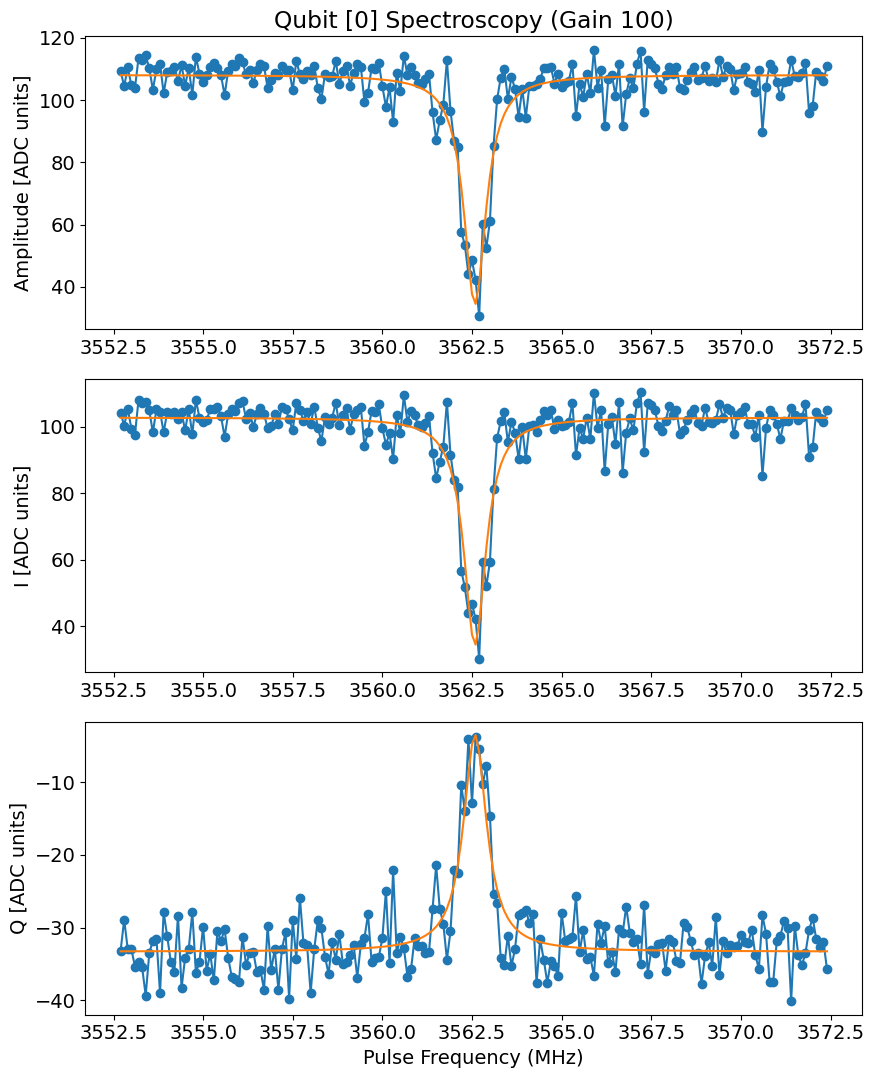

In [17]:
gespec_expt.display()

## Amplitude Rabi

In [19]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.config_thisrun.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.config_thisrun.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.config_thisrun.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

In [20]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.AmplitudeRabiExperiment,
    default_expt_cfg=amprabi_defaults,
    preprocessor=amprabi_preproc,
    postprocessor=amprabi_postproc,
    job_client=client,
    user="connie",
)

amprabi_expt = amprabi_runner.run(
    # relax_delay=2500,
    # post_process=True,
)

Job submitted: JOB-20260114-00023 (queue position: 1)
[2.0s] Job JOB-20260114-00023: running
[83.0s] Job JOB-20260114-00023: completed
Job completed! Data: D:\experiments\260114_job_worker\data\JOB-20260114-00023_AmplitudeRabiExperiment.h5
Updated qubit ge pi and hpi gaussian gain!


## Summary

In [23]:
print("JOB AND CONFIG IDS")

# Qubit Spectroscopy
spec_result = gespec_runner.last_job_result
print(f"\nQubit Spectroscopy:")
print(f"  Job ID:                   {spec_result.job_id}")
print(f"  Hardware Config:          {spec_result.hardware_config_version_id}")
print(f"  Data File:                {spec_result.data_file_path}")
print(f"  Expt Object Pickle File:  {spec_result.expt_pickle_path}")

# Amplitude Rabi
rabi_result = amprabi_runner.last_job_result
print(f"\nAmplitude Rabi:")
print(f"  Job ID:                   {rabi_result.job_id}")
print(f"  Hardware Config:          {rabi_result.hardware_config_version_id}")
print(f"  Data File:                {rabi_result.data_file_path}")
print(f"  Expt Object Pickle File:  {rabi_result.expt_pickle_path}")

print("\n" + "=" * 60)
print("CALIBRATION RESULTS")
print("=" * 60)
print(f"Qubit frequency:  {station.config_thisrun.device.qubit.f_ge[0]} MHz")
print(f"Pi-pulse gain:    {station.config_thisrun.device.qubit.pulses.pi_ge.gain[0]}")

JOB AND CONFIG IDS

Qubit Spectroscopy:
  Job ID:                   JOB-20260114-00021
  Hardware Config:          CFG-HW-20260114-00001
  Data File:                D:\experiments\260114_job_worker\data\JOB-20260114-00021_PulseProbeSpectroscopyExperiment.h5
  Expt Object Pickle File:  D:\experiments\260114_job_worker\expt_objs\JOB-20260114-00021_expt.pkl

Amplitude Rabi:
  Job ID:                   JOB-20260114-00023
  Hardware Config:          CFG-HW-20260114-00001
  Data File:                D:\experiments\260114_job_worker\data\JOB-20260114-00023_AmplitudeRabiExperiment.h5
  Expt Object Pickle File:  D:\experiments\260114_job_worker\expt_objs\JOB-20260114-00023_expt.pkl

CALIBRATION RESULTS
Qubit frequency:  3562.5777388380297 MHz
Pi-pulse gain:    4718


## Queue Status

In [2]:
# Check server health
health = client.health_check()
print(f"Server status:    {health['status']}")
print(f"Pending jobs:     {health['pending_jobs']}")
print(f"Running jobs:     {health['running_jobs']}")

Server status:    healthy
Pending jobs:     0
Running jobs:     0


In [25]:
# View current queue (pending and running jobs)
client.print_queue()


=== Job Queue ===

No job currently running

Pending: 0 jobs



In [3]:
# View recent job history
print("Recent Job History:")
print("-" * 80)
history = client.get_history(limit=10)

for job in history:
    job_id = job['job_id']
    result = client.get_status(job_id)
    print(f"{job_id} {job['user']}\t{job['status']:10s}  {job['experiment_class']}\t{result.data_file_path}")

Recent Job History:
--------------------------------------------------------------------------------
JOB-20260114-00023 connie	completed   AmplitudeRabiExperiment	D:\experiments\260114_job_worker\data\JOB-20260114-00023_AmplitudeRabiExperiment.h5
JOB-20260114-00022 connie2	completed   PulseProbeSpectroscopyExperiment	D:\experiments\260114_job_worker\data\JOB-20260114-00022_PulseProbeSpectroscopyExperiment.h5
JOB-20260114-00021 connie	completed   PulseProbeSpectroscopyExperiment	D:\experiments\260114_job_worker\data\JOB-20260114-00021_PulseProbeSpectroscopyExperiment.h5
JOB-20260114-00020 connie2	cancelled   PulseProbeSpectroscopyExperiment	None
JOB-20260114-00019 connie	completed   PulseProbeSpectroscopyExperiment	D:\experiments\260114_job_worker\data\JOB-20260114-00019_PulseProbeSpectroscopyExperiment.h5
JOB-20260114-00018 connie	completed   PulseProbeSpectroscopyExperiment	D:\experiments\260114_job_worker\data\JOB-20260114-00018_PulseProbeSpectroscopyExperiment.h5
JOB-20260114-00017 

## Config Versioning

The job system tracks versioned snapshots of config files. Key operations:

1. **View available versions** - List all snapshots of a config type
2. **Create a new version** - Snapshot a config file (automatically done by worker, or manually)
3. **Set main config** - Point "main" to a specific version ID
4. **Pull main config** - Get the path to the current main config

In [31]:
from pathlib import Path
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager
from job_server.models import ConfigType

# Initialize database and config manager
db = get_database()

# Adjust this path to your multimode_expts location
CONFIG_DIR = Path("D:/python/multimode_expts/configs")
config_manager = ConfigVersionManager(CONFIG_DIR)

In [32]:
# 1. List all available config versions
print("Available Hardware Config Versions:")
print("-" * 70)

with db.session() as session:
    versions = config_manager.list_versions(ConfigType.HARDWARE_CONFIG, session)
    for v in versions[:10]:  # Show last 10
        print(f"  {v.version_id}  {v.original_filename}  ({v.created_at})")

Available Hardware Config Versions:
----------------------------------------------------------------------
  CFG-HW-20260114-00001  hardware_config_202505.yml  (2026-01-14 23:11:59.829548)


In [33]:
# 2. Create a new config version (snapshot a config file)
# This creates a versioned copy with a unique ID like CFG-HW-20260114-00001

HARDWARE_CONFIG_PATH = CONFIG_DIR / "hardware_config_202505.yml"

with db.session() as session:
    version_id, snapshot_path = config_manager.snapshot_hardware_config(
        source_path=HARDWARE_CONFIG_PATH,
        session=session,
        job_id=None,  # Optional: link to a job
    )
    print(f"Created config version: {version_id}")
    print(f"Snapshot saved to: {snapshot_path}")

[CONFIG] Reusing existing version CFG-HW-20260114-00001 (same checksum)
Created config version: CFG-HW-20260114-00001
Snapshot saved to: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260114-00001_hardware_config_202505.yml


In [35]:
# 3. Set a specific version as the "main" config
# This is useful when you want to switch back to a previous known-good config

# First, let's see what the current main config is (if any)
with db.session() as session:
    main_config = config_manager.get_main_version(ConfigType.HARDWARE_CONFIG, session)
    if main_config:
        print(f"Current main config: {main_config.version_id}")
    else:
        print("No main config set yet")

# Now set a specific version as main
# Replace with an actual version_id from the list above
with db.session() as session:
    # Get the most recent version to use as an example
    versions = config_manager.list_versions(ConfigType.HARDWARE_CONFIG, session)
    if versions:
        example_version_id = versions[0].version_id  # Most recent
        config_manager.set_main_version(
            config_type=ConfigType.HARDWARE_CONFIG,
            version_id=example_version_id,
            session=session,
            updated_by="Claude",
        )
        print(f"Set main config to: {example_version_id}")

No main config set yet
[CONFIG] Set main hardware_config to CFG-HW-20260114-00001
Set main config to: CFG-HW-20260114-00001


In [36]:
# 4. Get/pull the main config path
# Use this when you need to load the current "canonical" config

with db.session() as session:
    main_path = config_manager.get_main_config_path(ConfigType.HARDWARE_CONFIG, session)
    if main_path:
        print(f"Main config path: {main_path}")
        print(f"File exists: {main_path.exists()}")
    else:
        print("No main config path set")

Main config path: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260114-00001_hardware_config_202505.yml
File exists: True


In [37]:
# 5. Push: Snapshot a config AND set it as main in one step
# This is the most common operation when you've updated your config and want to publish it

with db.session() as session:
    version_id, snapshot_path = config_manager.push_hardware_config_to_main(
        source_path=HARDWARE_CONFIG_PATH,
        session=session,
        updated_by="Claude",
    )
    print(f"Created and set as main: {version_id}")
    print(f"Snapshot path: {snapshot_path}")

[CONFIG] Reusing existing version CFG-HW-20260114-00001 (same checksum)
[CONFIG] Updated main hardware_config to CFG-HW-20260114-00001
Created and set as main: CFG-HW-20260114-00001
Snapshot path: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260114-00001_hardware_config_202505.yml


### Using Config Versions with Jobs

When jobs run, the worker automatically snapshots the current configs and records the version IDs with the job. You can see which config versions were used by checking `last_job_result`:

```python
result = runner.last_job_result
print(f"Hardware config used: {result.hardware_config_version_id}")
print(f"Multiphoton config used: {result.multiphoton_config_version_id}")
```

The worker uses the configs from the station's paths at execution time. Config versioning is primarily for:
1. **Reproducibility** - Know exactly which config was used for each job
2. **Rollback** - Switch "main" back to a previous known-good config
3. **Audit trail** - Track config changes over time